# Project on frame buckling

1. Define a new class `Frame_Buckling` as a child of the class `LinearFrame` provided in `frame.py`. Add in this class methods to extract the **normal stress** $\bar N_0$ in each bar and to assemble the *geometric stiffness* $G$.


2. Solve the buckling problem for a simply supported straight beam using the `Frame_Buckling` class and compare with the analytical solution (see e.g. cours/TD 3A103) when using different number of element. 



3. Solve the buckling problem for the frame of the Exercise 2 in the notebook 02-LinearFrame. Compare with the experimental findings on the first buckling load and mode. Represent the first 2 buckling modes.



4. Propose an improved geometry of the frame  of the Exercise 2 in the notebook 02-LinearFrame to increase the buckling load. Support your proposal with numerical results.


(For classes in `python` you can look https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes, for example)

In [2]:
%matplotlib inline  
from sympy.interactive import printing
printing.init_printing()
from frame import *
import sympy as sp
import numpy as np

In [3]:
class Frame_Buckling(LinearFrame):

    def N_local_stress(self,element):

        """
        Returns the normal forces of an element.
        """
        Ke= self.K_local()
        Ue= self.U_e_local_coord(element)
        F=Ke*Ue
        N_local = F[3]
        return N_local
    
    def find_T_local(self,element):
        """
        Returns the tangential forces of an element.
        """
        Ke= self.K_local()
        Ue= self.U_e_local_coord(element)
        F=np.dot(Ke,Ue)
        T_local = F[4]
        return T_local
    
    def find_M_local(self,element):
        """
        Returns the moments of an element.
        """
        Ke= self.K_local()
        Ue= self.U_e_local_coord(element)
        F=np.dot(Ke,Ue)
        M_local = F[5]
        return M_local
    
    def N_local_stress_tot(self):

        """
        Returns the normal force of all elements.
        """
        N_local=np.zeros([self.nelements])
        for e in range(self.nelements):
            Ke= self.K_local()
            Ue= self.U_e_local_coord(e)
            F=np.matrix(Ke)*np.array(Ue)
            N_local[e]= F[3]
        return N_local
    
    def G_local(self):
        """
        Returns the global geometric stiffness matrix
        """
        L = sp.Symbol('L')
        s = sp.Symbol('s')
        S=self.S()
        Ge=sp.Matrix([[sp.integrate(S[1,i_local].diff(s)*S[1,j_local].diff(s),(s,0,L) )for i_local in range(6)] for j_local in range(6)]) 
        return Ge
    
    def G_local_rotated(self):
        """
        Gives the analytical expression the local geometric stiffness matrix in the global coordinate system 
        as a function of the orientation angle alpha
        """
        alpha = sp.Symbol("alpha")
        R = self.rotation_matrix(alpha)
        Ge = R.transpose()*self.G_local()*R
        return Ge
    
    def assemble_G(self):
        """
        Returns the global stiffness matrix
        """
        Ge = self.G_local_rotated()
        G = np.zeros([self.ndof,self.ndof])
        N0=self.N_local_stress_tot()
        # add rotation
        for e in range(self.nelements):
            Gen = -N0[e]*np.array(Ge.subs({ 'L': self.Ls[e], 'alpha': self.angles[e]}))
            for i_local in range(6):
                for j_local in range(6):
                    G[self.dof_map(e, i_local),self.dof_map(e, j_local)] += Gen[i_local,j_local]
        return G

In [4]:
E=1.3 #en MPa
h=7.5 #en mm
b=20. #en mm
Lx=55. #en mm
Lyh=60. #en mm
Lyb=45. #en mm
I=b*(h**3)/12 #en mm^4
S=b*h  #en mm^2
eps=10**(-3)
g=9.81
m=0.05

Frame with
7 elements
7 nodes
21 dofs


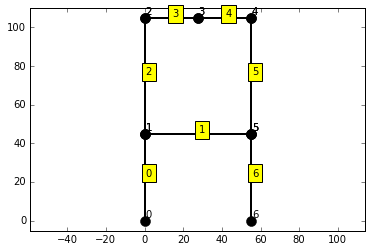

In [5]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [6]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(7)
f_y = 0*np.ones(7)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [7]:
K = frame.assemble_K()
F=frame.assemble_F()
F[10]=F[10]-m*g
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -9.05234017e-03,  -5.65961538e-02,   6.63963901e-03,
         6.67003320e-03,  -1.32057692e-01,  -3.82096908e-02,
         6.49441927e-16,  -1.12243774e+00,  -1.42632649e-19,
        -6.67003320e-03,  -1.32057692e-01,   3.82096908e-02,
         9.05234017e-03,  -5.65961538e-02,  -6.63963901e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [20]:
Nloc=frame.N_local_stress_tot()
Nloc
Ke= frame.K_local()
Ue= frame.U_e_local_coord(6)
A=frame.angle(6)
print(Ke)
print(Ue)
print(A)

Matrix([[ES/L, 0, 0, -ES/L, 0, 0], [0, 12*EI/L**3, 6*EI/L**2, 0, -12*EI/L**3, 6*EI/L**2], [0, 6*EI/L**2, 4*EI/L, 0, -6*EI/L**2, 2*EI/L], [-ES/L, 0, 0, ES/L, 0, 0], [0, -12*EI/L**3, -6*EI/L**2, 0, 12*EI/L**3, -6*EI/L**2], [0, 6*EI/L**2, 2*EI/L, 0, -6*EI/L**2, 4*EI/L]])
Matrix([[0], [0], [0], [0], [0], [0]])
-1.57079632679


In [9]:
Ge=frame.G_local()
print(Ge)

Matrix([[0, 0, 0, 0, 0, 0], [0, 6/(5*L), 1/10, 0, -6/(5*L), 1/10], [0, 1/10, 2*L/15, 0, -1/10, -L/30], [0, 0, 0, 0, 0, 0], [0, -6/(5*L), -1/10, 0, 6/(5*L), -1/10], [0, 1/10, -L/30, 0, -1/10, 2*L/15]])


In [10]:
G=frame.assemble_G()
G

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  